### 策略测试

#### 测试步骤
- 读取价格数据
- 数据转化为周线（或月线）
- 设定初始权重和目标风险分配比例
- 调用风险平价模型计算，计算动态权重 *如不使用r、cov，需重新编写get_w函数*
- 计算策略回报

#### 策略

构建新Cov矩阵，以价格到均线距离调整var(i)的数值，再运用风险平价模型计算权重。

var计算 - 分为两个区间slope<0和slope>=0，将值分别映射到[2.0-0.0]和[0.0-2.0]，乘以历史var

cov计算 - 暂按历史值

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
import time
import requests
from itertools import combinations
import itertools
from IPython.core.display import HTML

In [2]:
# Read data from CSV files

def read_csv(etf_tickers, end_date):
    
    pl = None
    
    for e in etf_tickers:
        # Read
        csv_filename = e+end_date+'.csv'
        df = pd.read_csv(csv_filename)
        p_t=['Date','Adj Close']
        p=df[p_t].sort_values(by='Date')
        p['Date'] = pd.to_datetime(p['Date'])
        p.set_index("Date", inplace=True)
        p = p.rename({'Adj Close':e}, axis=1)
        
        # Merge
        if pl is None:
            pl=p
        else:
            pl = pd.merge(pl,p,left_index=True, right_index=True)
        
    return pl

# get weights via Parity Model

from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 平滑权重

def smooth_w(w, f=0.05):
    e0=w.columns[0]
    for i in range(1,len(w)):
        w[e0][i]=1.0
        for e in w.columns[1:len(w.columns)]:
            if w[e][i]/w[e][i-1]>1+f:
                w[e][i]=(1+f)*w[e][i-1]
            elif w[e][i]/w[e][i-1]<1-f:
                w[e][i]=(1-f)*w[e][i-1]
            w[e0][i]=w[e0][i]-w[e][i]    
    return w

#绘制策略结果

def plot_performance(r, w, v, totalreturn, std, maxloss, k='Total'):
    per = r.copy()
    # Results
    t_head='{:15}'.format(str(k))
    t1='{:15}'.format('Return')
    #t2='{:15}'.format('STD')
    t3='{:15}'.format('MaxLoss')
    for e in per.columns:
        t_head= t_head+'{:>15}'.format(e)
    for i in range(0, len(totalreturn)):        
        t1=t1+'{:>12}'.format('%0.2f%%' %(totalreturn[i]*100))
        #t2=t2+'{:>15}'.format('%0.2f%%' %(std[i]*100))
        t3=t3+'{:>12}'.format('%0.2f%%' %(-maxloss[i]*100))
    #t=t_head+'\n'+t1+'\n'+t2+'\n'+t3
    t=t_head+'\n'+t1+'\n'+t3
    
    # Plot
    row = 2
    col = 3
    gridsize = (row, col) # (row,col)
    fig = plt.figure(figsize=(row*8, col*2*row))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan=1, rowspan=1)
    #ax3 = plt.subplot2grid(gridsize, (0, 2), colspan=1, rowspan=1)

    for i in range(0,len(per.columns)-1):
        ax1.plot(per[per.columns[i]], linewidth=1)
    ax1.plot(per[per.columns[len(per.columns)-1]], color='black', linewidth=2)
    ax1.legend()
    ax1.set_title(t, loc='left')
    
    #labels = wy.columns.values.tolist()
    ax2.stackplot(w.index, w.values.T)
    #ax2.legend()

#计算策略回报
def get_performance(p, w):
    v, w = get_value(p, w)
    r = v.copy()
    for e in r.columns:
        r[e]=r[e].pct_change()
    for e in r.columns:
        r[e][0]=1.0
        for i in range(1,len(r)):        
            r[e][i]=(1+r[e][i])*r[e][i-1]
     
    l=len(r)-1
    maxloss = []   
    for e in r.columns:
        m=0
        for i in range(1,l):
            d = 1 - min(r[e][i:l+1])/r[e][i-1]
            if m<d:
                m=d
        maxloss.append(m)
    totalreturn = []
    for e in r.columns:
        totalreturn.append(r[e][l]-1)
    std = []
    for e in r.columns:
        std.append(r[e].std())
        
    return r, v, w, totalreturn, std, maxloss

def get_value(p, w0, fund=1000000):
    w = w0.copy()
    v = p.copy()
    v['Portfolio'] = v.sum(axis=1)
    s = p.copy()
    v['Portfolio'][0] = 0.0
    e0=s.columns[0] # SHY
    for e in s.columns:
        s[e][0] = fund*w[e][0]/p[e][0]
        v[e][0] = s[e][0] * p[e][0]
        v['Portfolio'][0] = v['Portfolio'][0] + v[e][0]
    for i in range(1,len(v)):
        d_f = 0.0
        v['Portfolio'][i] = 0.0
        for e in s.columns:
            if e != e0:
                d_s = (w[e][i]/w[e][i-1]-1)*s[e][i-1] # buy or sell new shares at t
                s[e][i] = d_s + s[e][i-1]
                d_f = d_f + d_s * p[e][i] # cash balance at t            
        # need net cash to buy share, so sell SHY
        d_s = d_f / p[e0][i]
        s[e0][i] = s[e0][i-1] - d_s
        # calc portfolio v at t
        for e in s.columns:
            v[e][i] = s[e][0] * p[e][i]
            v['Portfolio'][i] = v['Portfolio'][i] + v[e][i]
        
        # recalc weights
        for e in w.columns:
            w[e][i] = v[e][i]/v['Portfolio'][i]
            
    return v, w

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# distance to MA as var and slope as cov
def get_w(p, mc_budget, mp=52, dw=5):
    w0 = np.array([1 / p.shape[1]] * p.shape[1])
    
    # r
    r=p.copy()
    for e in r.columns:
        r[e]=r[e].pct_change()
    
    # ma
    ma = p.copy()
    for e in p.columns:
        ma[e] = p[e].rolling(mp,center=False,min_periods=1).mean()
    
    # distance
    dist = ma.copy()
    dist = p/ma-1
    
    # slope    
    slope = ma.copy()
    ln=len(slope)
    x=np.arange(1,dw+1)/100.0
    for e in p.columns:
        for i in range(mp,ln):
            y = ma[e][i-dw+1:i+1].values / ma[e][i-dw+1] - 1
            model = smf.OLS(y,x)
            results = model.fit()            
            slope[e][i] = results.params
            
    w = r.copy()        
    for i in range(mp,len(r)):
        cov = np.array(r[i-mp:i].cov())
        cov = cov_matrix(cov, dist.iloc[i], slope.iloc[i])
        w_tmp = _get_risk_parity_weights(cov, mc_budget, w0)
        w.iloc[i] = w_tmp
        for j in range(0,len(w_tmp)):
            if (w_tmp[j] is np.nan) or (w_tmp[j] != w_tmp[j]) or (w_tmp[j]<0) or (w_tmp[j]>1):
                w.iloc[i] = w.iloc[i-1]
        
    p =p.drop(p.index[0:mp+1])
    w =w.drop(w.index[0:mp+1])
    ma = ma.drop(ma.index[0:mp+1])
    dist = dist.drop(dist.index[0:mp+1])
    slope = slope.drop(slope.index[0:mp+1])
    
    return p, w, ma, slope

def cov_matrix(cov, d, s):
    ln = len(d)
    for i in range(0, ln):
        if s[i]<0:
            cov[i][i] = scale_number(d[i], 1.80, 0.20, 0.3, -0.3) * cov[i][i]
            #pass
        else:
            cov[i][i] = scale_number(d[i], 0.20, 1.80, -0.3, 0.3) * cov[i][i]
            #pass
        for j in range(i+1, ln):
        #    cov[i][j] = scale_number(s[i]*s[j]*10000, -0.1, 0.1, -1.0, 1.0)
            cov[i][j] = s[i]*s[j]/1000
            cov[j][i] = cov[i][j]
    return cov

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    scaled = (to_max - to_min) * (unscaled - from_min) / (from_max - from_min) + to_min
    return scaled

In [5]:
# set end_date
end_date = '2018-12-31'
comparable_ticker = 'SPY'
mc_budget = [0.1, 0.6, 0.2, 0.1]

In [6]:
# 读取数据
etf_tickers=['SHY','SPY','XLE','XLF']
pl=read_csv(etf_tickers, end_date)
portfolio = 'Protfolio'
#周线
wp = pl.resample('W', loffset=pd.offsets.timedelta(days=-6)).mean().dropna()

In [7]:
# get weights
p, w, ma, slope = get_w(wp, mc_budget)
#smooth weights
w = smooth_w(w)

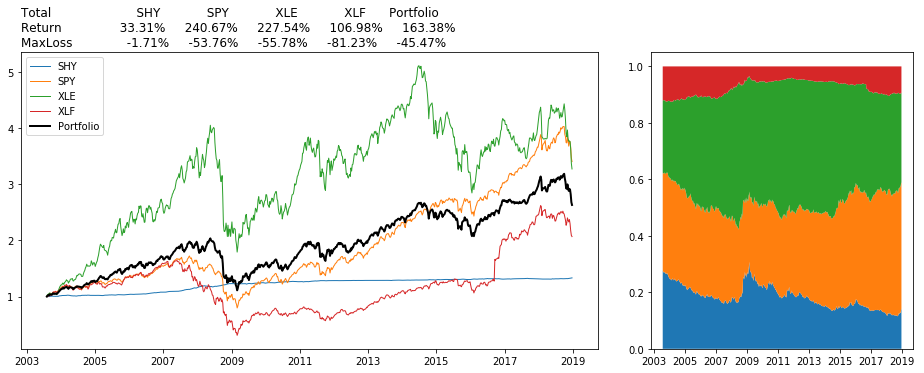

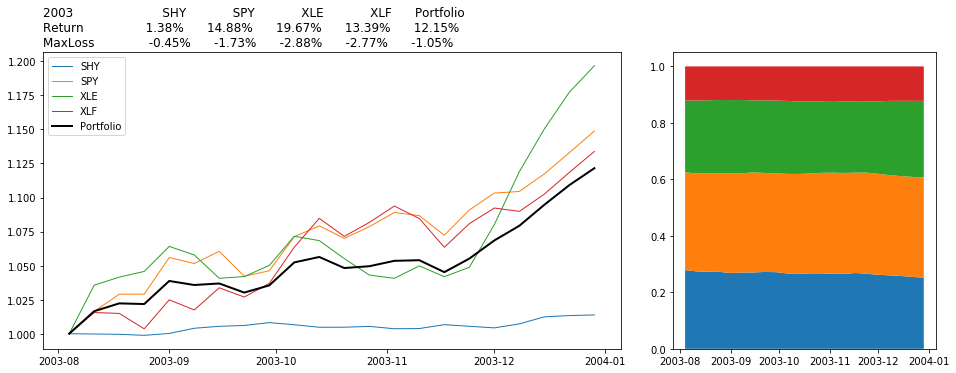

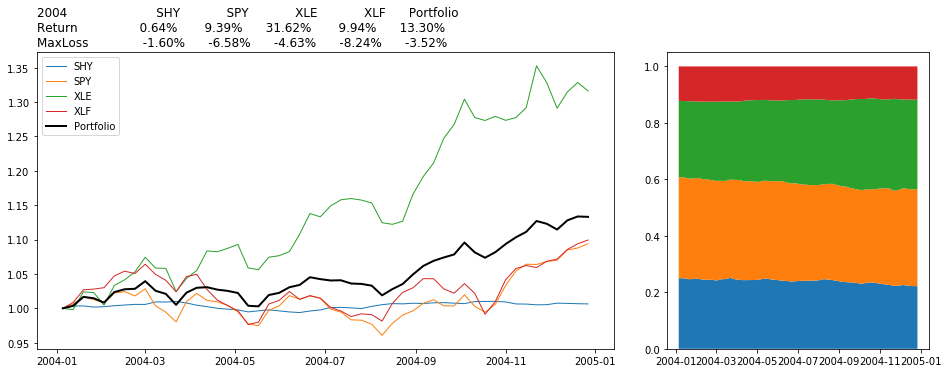

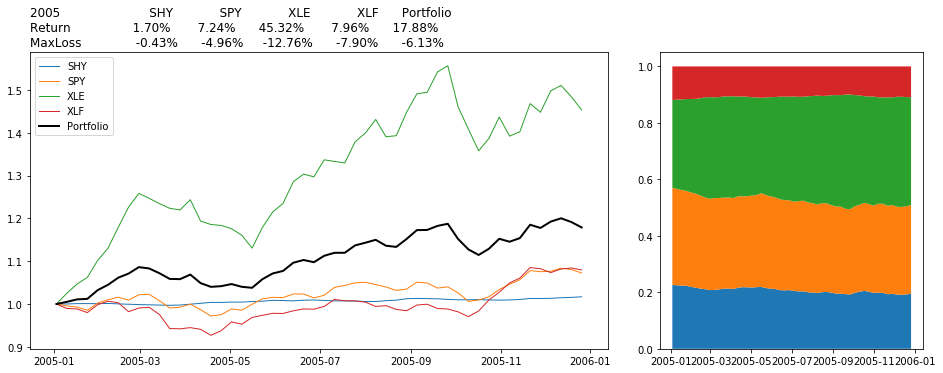

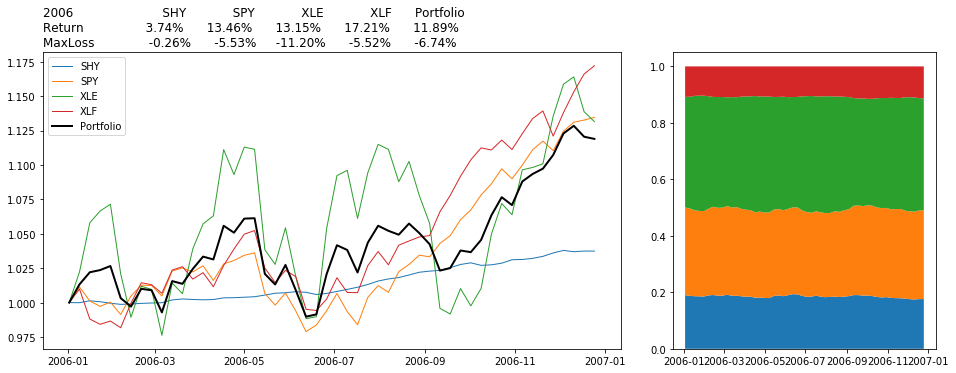

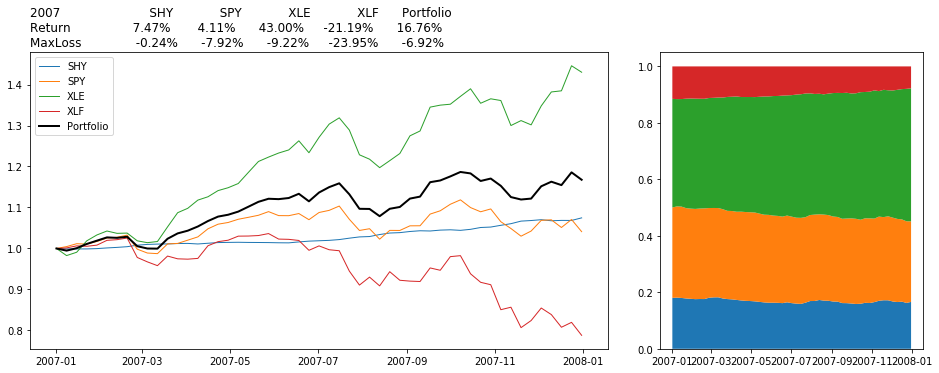

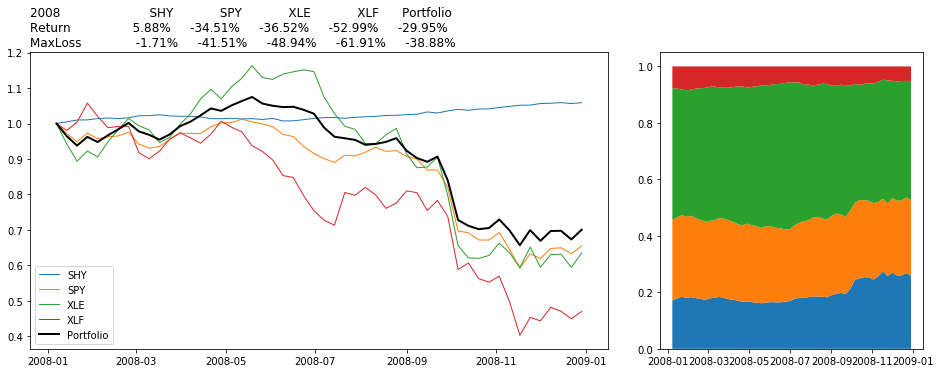

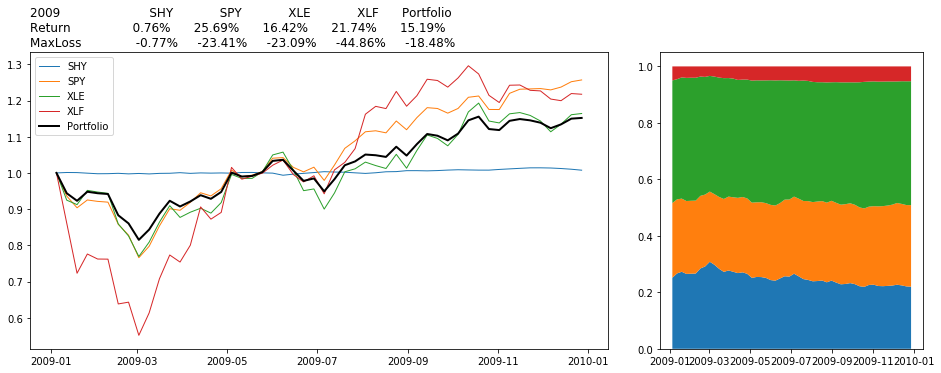

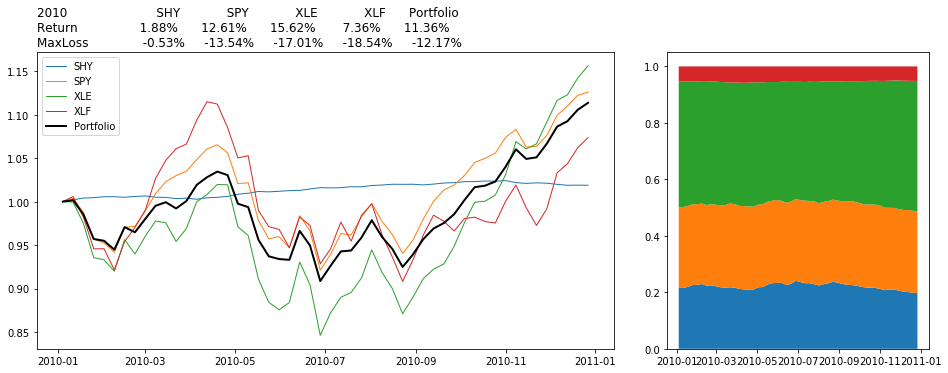

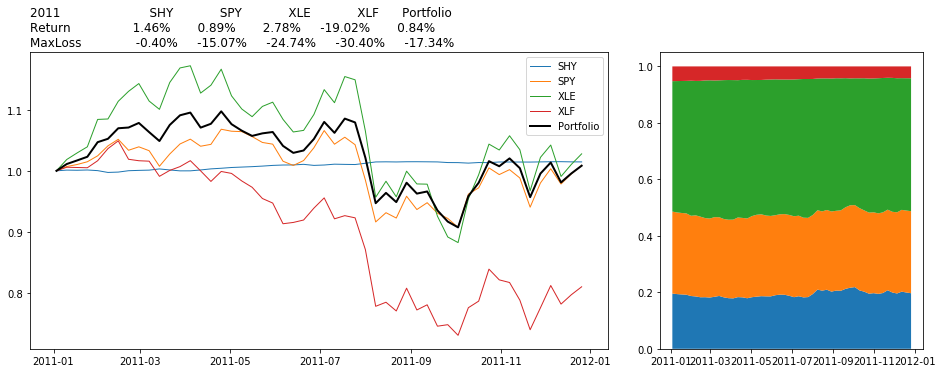

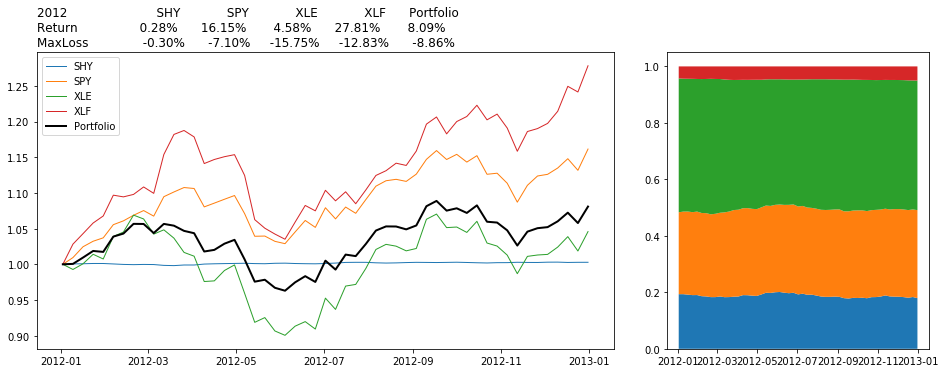

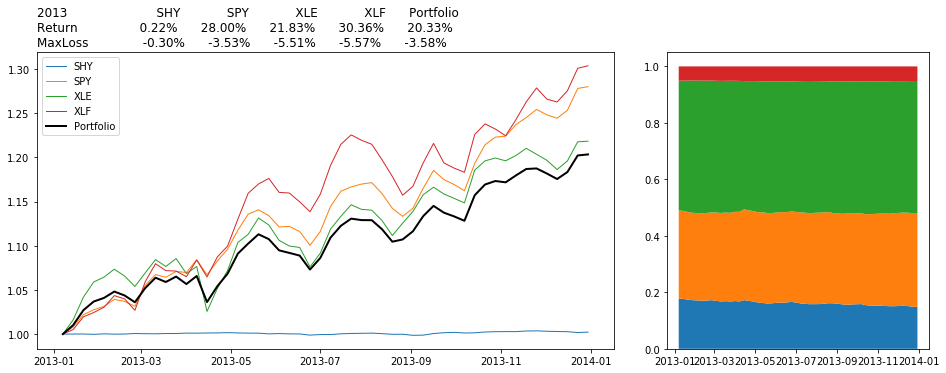

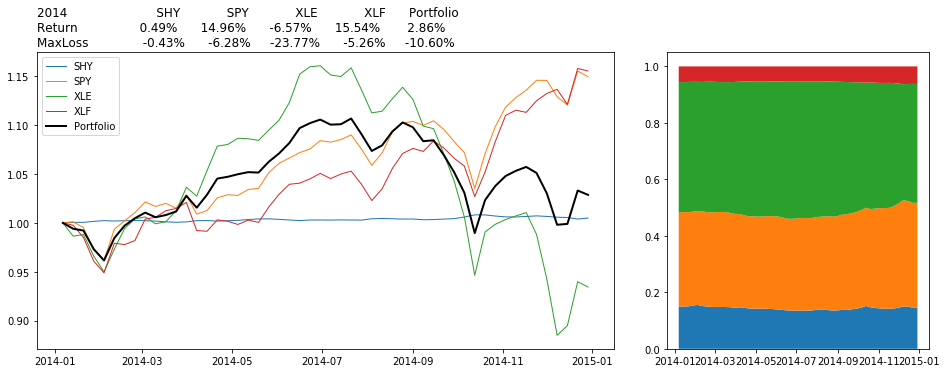

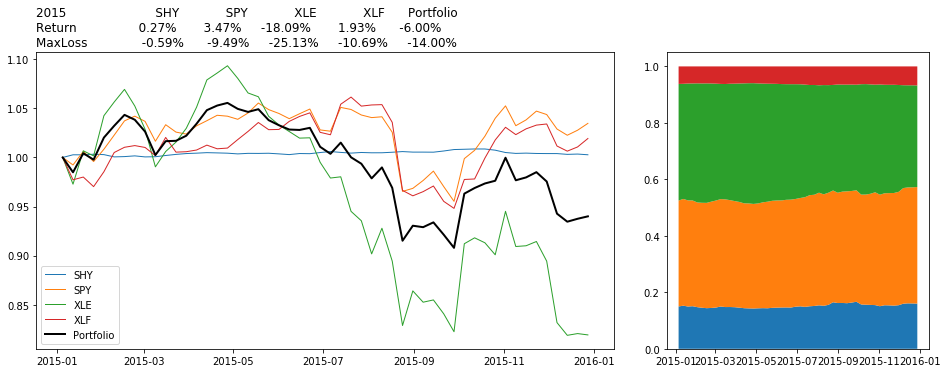

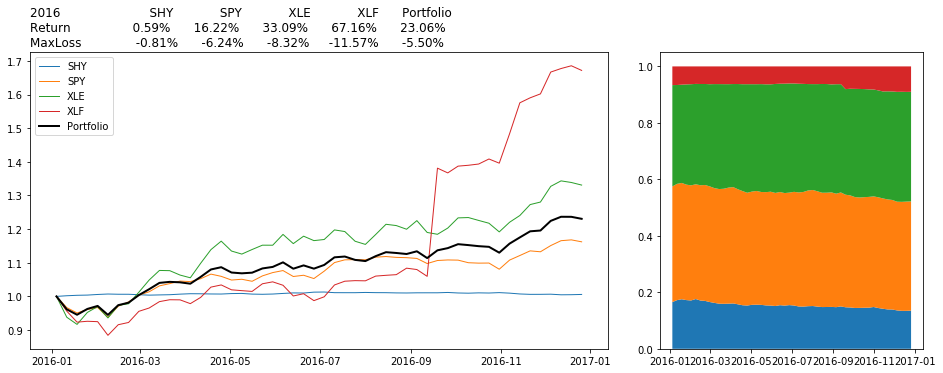

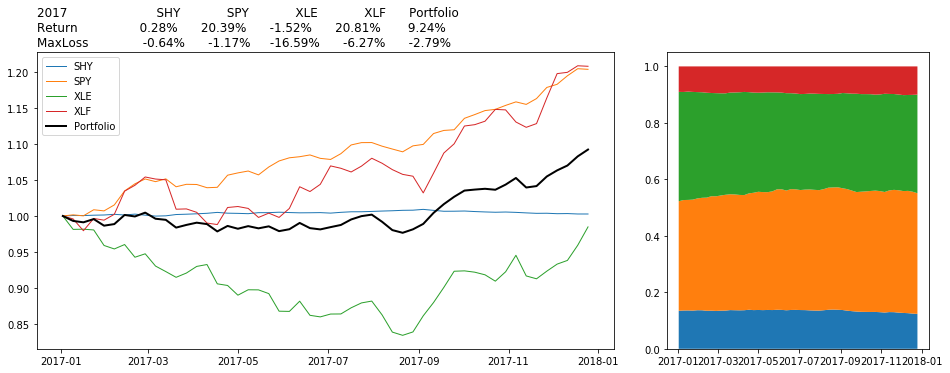

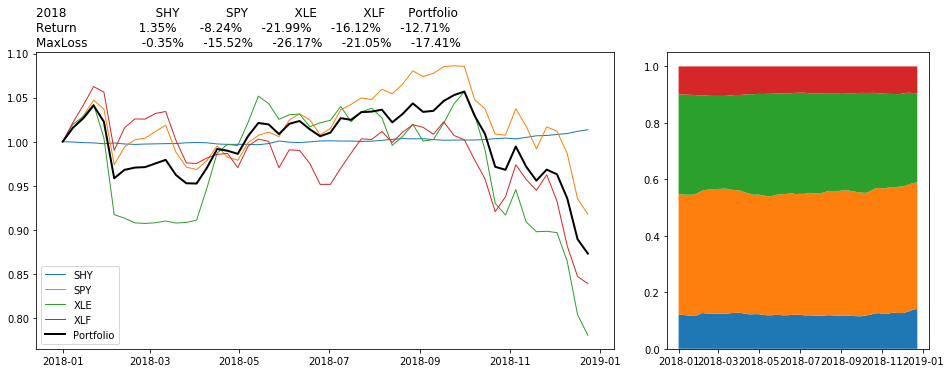

In [8]:
# plot the performance
r, v, w, totalreturn, std, maxloss = get_performance(p, w)
plot_performance(r, w, v, totalreturn, std, maxloss)
# slipt date by year
for k,g in itertools.groupby(p.index.year):
    py=p[p.index.year==k]
    wy=w[w.index.year==k]
    ry, vy, wy, totalreturny, stdy, maxlossy = get_performance(py, wy)
    plot_performance(ry, wy, vy, totalreturny, stdy, maxlossy, k)